In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import pickle
import xarray as xr
from datetime import datetime, timedelta
import numpy as np

# tk libs
from lib.objs.tkpaths import Site
from lib.KMA import KMA_simple
from lib.statistical import Persistences, ksdensity_CDF, ksdensity_ICDF, copulafit, copularnd
from lib.plotting.EOFs import Plot_EOFs_latavg as PlotEOFs
from lib.plotting.KMA import Plot_Weather_Types
from lib.PCA import CalcPCA_latavg as CalcPCA
from lib.PCA import CalcRunningMean
from lib.objs.alr_wrapper import ALR_WRP
from lib.io.aux_nc import StoreBugXdset as sbxds
from lib.custom_dateutils import xds_reindex_daily as xr_daily
from lib.custom_dateutils import xds_reindex_monthly as xr_monthly


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

# input files
p_SST = site.pc.DB.sst.hist_pacific  # SST Pacific area

# output files
p_export_figs = site.pc.site.exp.sst
p_sst_PCA = site.pc.site.sst.PCA
p_sst_KMA = site.pc.site.sst.KMA
p_sst_alrw = site.pc.site.sst.alrw
p_PCs_sim = site.pc.site.sst.PCs_sim
p_PCs_sim_d = site.pc.site.sst.PCs_sim_d
p_PCs_sim_m = site.pc.site.sst.PCs_sim_m

# PCA dates parameters
pred_name = 'SST'
y1 = int(site.params.SST_AWT.pca_year_ini)
yN = int(site.params.SST_AWT.pca_year_end)
m1 = int(site.params.SST_AWT.pca_month_ini)
mN = int(site.params.SST_AWT.pca_month_end)
num_clusters = int(site.params.SST_AWT.num_clusters)
repres = float(site.params.SST_AWT.repres)
num_PCs_rnd = int(site.params.SST_AWT.num_pcs_rnd)

# Simulation dates (ALR)
y1_sim = int(site.params.SIMULATION.date_ini.split('-')[0])
y2_sim = int(site.params.SIMULATION.date_end.split('-')[0])



Calculating SST running average... 

Principal Component Analysis (latitude average)...
Principal Components Analysis COMPLETE
<xarray.Dataset>
Dimensions:        (n_components: 137, n_features: 972, n_lon: 81)
Dimensions without coordinates: n_components, n_features, n_lon
Data variables:
    var_anom_mean  (n_features) float64 0.004979 0.00597 ... 0.008235 0.008039
    var_anom_std   (n_features) float64 0.182 0.1846 0.2079 ... 0.9462 0.908
    PCs            (n_components, n_components) float64 7.972 ... 9.567e-15
    pred_lon       (n_lon) float32 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
    variance       (n_components) float64 467.5 99.72 ... 4.251e-05 9.22e-29
    EOFs           (n_components, n_features) float64 -0.006245 ... -0.02134
Attributes:
    y1:       1880
    y2:       2016
    m1:       6
    method:   latitude averaged
    m2:       5


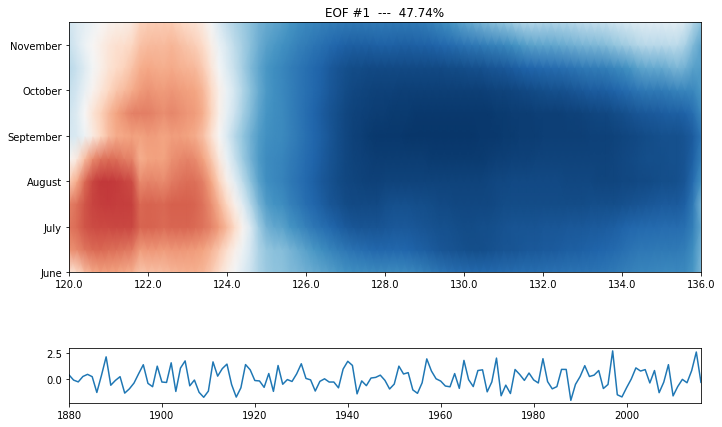

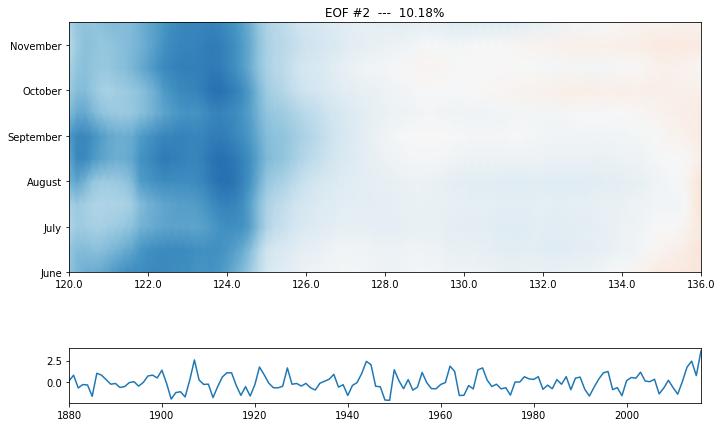

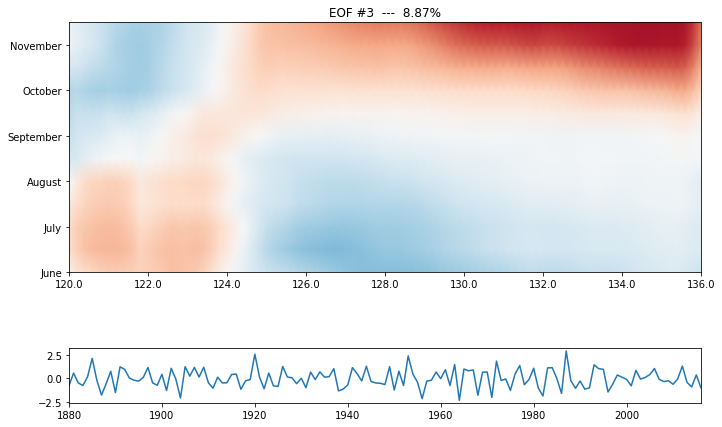

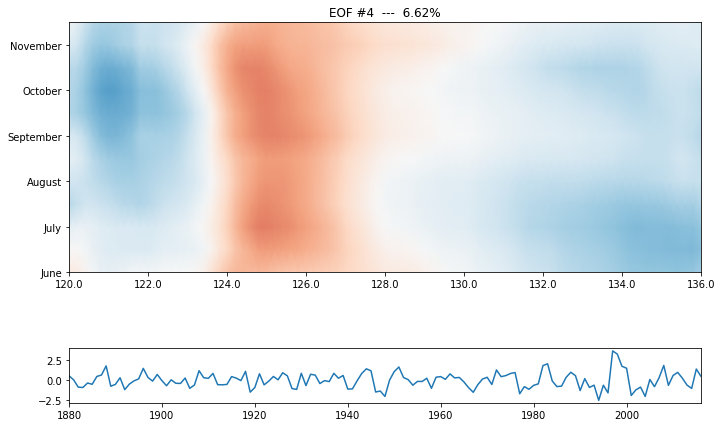

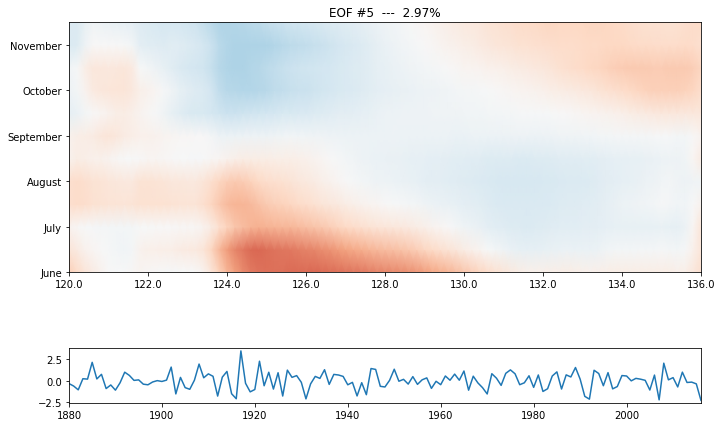

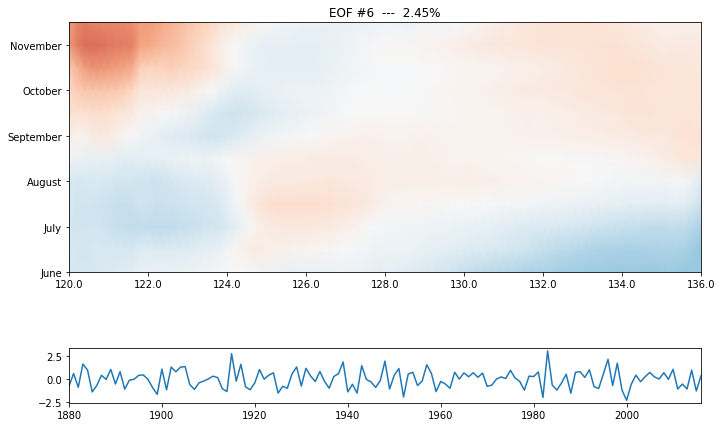

In [2]:
# --------------------------------------
# load SST predictor from database
xds_pred = xr.open_dataset(p_SST)


# --------------------------------------
# Calculate running average
print('\nCalculating {0} running average... '.format(pred_name))
xds_pred = CalcRunningMean(xds_pred, pred_name)

# Principal Components Analysis
print('\nPrincipal Component Analysis (latitude average)...')
xds_PCA = CalcPCA(xds_pred, pred_name, y1, yN, m1, mN)
print xds_PCA

# plot EOFs
n_plot = 6
PlotEOFs(xds_PCA, n_plot)



KMA Classification...
KMEANS classification COMPLETE.
<xarray.Dataset>
Dimensions:         (n_clusters: 6, n_features: 28, n_pcacomp: 137, n_pcafeat: 972)
Dimensions without coordinates: n_clusters, n_features, n_pcacomp, n_pcafeat
Data variables:
    cenEOFs         (n_clusters, n_features) float64 -28.15 -6.434 ... 0.01138
    variance        (n_pcacomp) float64 467.5 99.72 86.87 ... 4.251e-05 9.22e-29
    Km              (n_clusters, n_pcafeat) float64 0.005448 ... -0.02854
    PCs             (n_pcacomp, n_features) float64 7.972 1.668 ... -0.06965
    bmus_corrected  (n_pcacomp) int64 3 2 3 3 3 2 4 3 1 2 ... 2 0 4 4 2 5 0 1 5
    bmus            (n_pcacomp) int32 4 1 4 4 4 1 0 4 3 1 ... 1 2 0 0 1 5 2 3 5
    order           (n_clusters) int64 2 3 1 4 0 5
    centroids       (n_clusters, n_pcafeat) float64 0.002581 ... -0.04028
    group_size      (n_clusters) int64 28 28 18 18 26 19

SST PCA and KMA stored at:
/Users/nico/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/SS

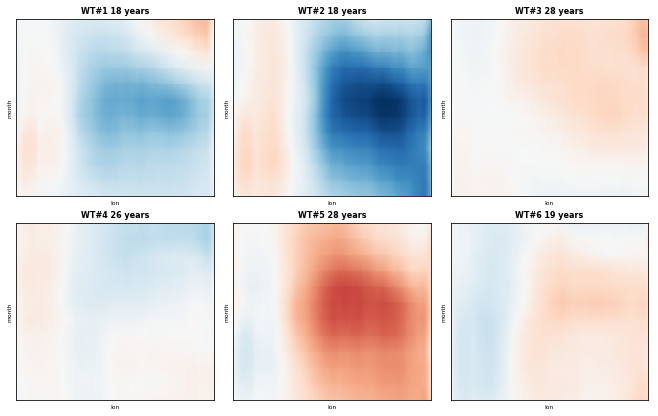

In [3]:
# --------------------------------------
# KMA Classification 
# TODO: A VECES SALE UN CLUSTER DE MAS ?
print('\nKMA Classification...')
xds_AWT = KMA_simple(
    xds_PCA, num_clusters, repres)
print xds_AWT

# PCA, KMA  dates (annual array)
dates_fit = [datetime(y,m1,01) for y in range(y1,yN+1)]
xds_PCA['time']=(('n_components'), dates_fit)
xds_AWT['time']=(('n_pcacomp'), dates_fit)

# store AWTs and PCs
xds_PCA.to_netcdf(p_sst_PCA,'w')  # store SST PCA data 
xds_AWT.to_netcdf(p_sst_KMA,'w')  # store SST KMA data 
print('\n{0} PCA and KMA stored at:\n{1}\n{2}'.format(
    pred_name, p_sst_PCA, p_sst_KMA))

# Plot Weather Types
Plot_Weather_Types(xds_AWT, xds_PCA.pred_lon)

# TODO plot year/label WTs

In [5]:
# --------------------------------------
# Get more data from xds_AWT
kma_order = xds_AWT.order.values
kma_labels = xds_AWT.bmus.values

# Get bmus Persistences
#d_pers_bmus = Persistences(xds_AWT.bmus.values)

# first 3 PCs
PCs = xds_AWT.PCs.values
variance = xds_AWT.variance.values
PC1 = np.divide(PCs[:,0], np.sqrt(variance[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(variance[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(variance[2]))

# for each WT: generate copulas and simulate data 
d_pcs_fit = {}
d_pcs_rnd = {}
for i in range(num_clusters):

    # getting copula number from plotting order
    num = kma_order[i]

    # find all the best match units equal
    ind = np.where(kma_labels == num)[:]

    # transfom data using kernel estimator
    cdf_PC1 = ksdensity_CDF(PC1[ind])
    cdf_PC2 = ksdensity_CDF(PC2[ind])
    cdf_PC3 = ksdensity_CDF(PC3[ind])
    U = np.column_stack((cdf_PC1.T, cdf_PC2.T, cdf_PC3.T))

    # fit PCs CDFs to a gaussian copula 
    rhohat, _ = copulafit(U, 'gaussian')

    # simulate data to fill probabilistic space
    U_sim = copularnd('gaussian', rhohat, num_PCs_rnd)

    # get back PCs values from kernel estimator
    PC1_rnd = ksdensity_ICDF(PC1[ind], U_sim[:,0])
    PC2_rnd = ksdensity_ICDF(PC2[ind], U_sim[:,1])
    PC3_rnd = ksdensity_ICDF(PC3[ind], U_sim[:,2])

    # store data  # TODO : num o i????
    d_pcs_fit['wt_{0}'.format(num+1)] = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))
    d_pcs_rnd['wt_{0}'.format(num+1)] = np.column_stack((PC1_rnd, PC2_rnd, PC3_rnd))
    
# store WTS PC123 fit and rnd
p_pick = op.join(p_export_figs, 'd_pcs_fit.pickle')
pickle.dump(d_pcs_fit, open(p_pick, 'wb'))
p_pick = op.join(p_export_figs, 'd_pcs_rnd.pickle')
pickle.dump(d_pcs_rnd, open(p_pick, 'wb'))
    


Fitting autoregressive logistic model ...
Optimization done in 0.11 seconds

ALR model saved at /Users/nico/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/SST/alr_w/model.sav


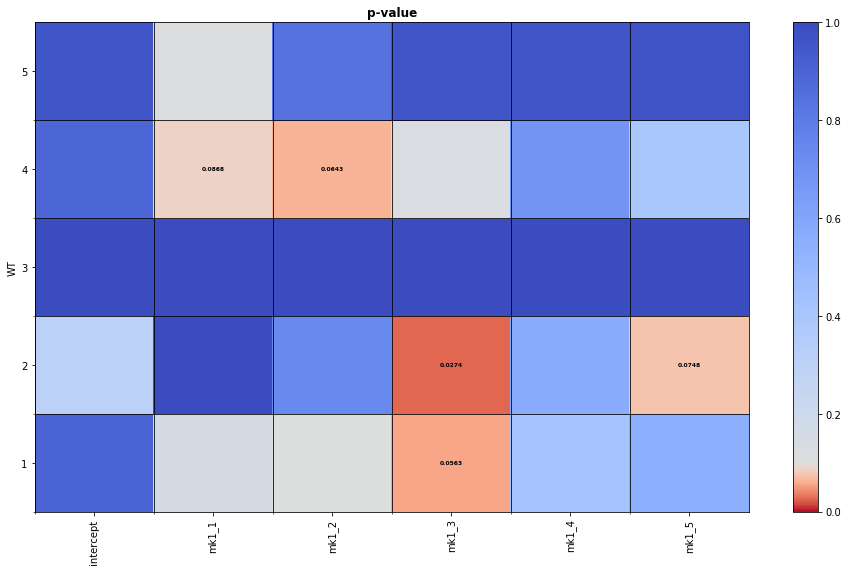

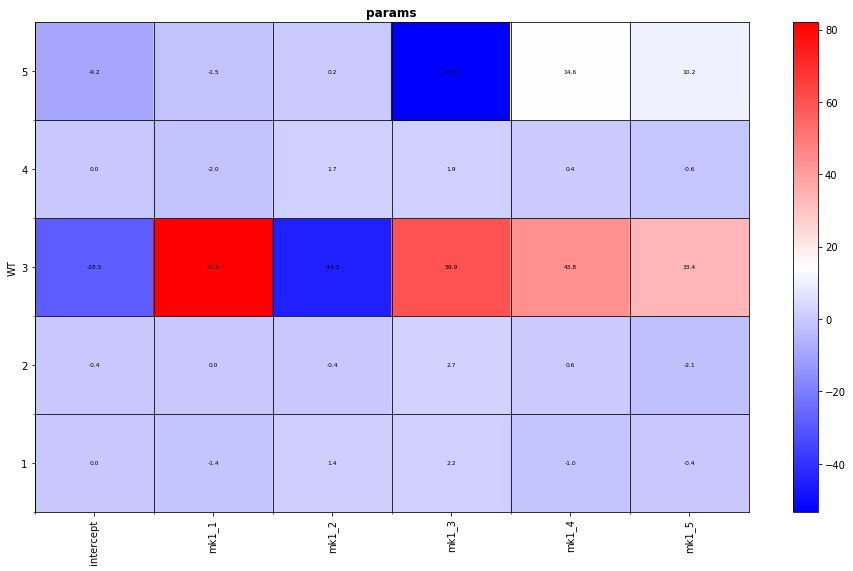

In [8]:
# --------------------------------------
# Autoregressive Logistic Regression
xds_bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), xds_AWT.bmus),
    },
    coords = {'time': xds_AWT.time.values}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : 1,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(p_sst_alrw)
ALRW.SetFitData(num_clusters, xds_bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)

# show fit report
ALRW.Report_Fit()


In [10]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y,m1,01) for y in range(y1_sim,y2_sim+1)]

# launch simulation
sim_num = 1
xds_alr = ALRW.Simulate(sim_num, dates_sim, progress_bar=False)
evbmus_sim = np.squeeze(xds_alr.evbmus_sims.values[:])


# Generate random PCs
print('\nGenerating PCs simulation: PC1, PC2, PC3 (random value withing category)...')
pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
for c, m in enumerate(evbmus_sim):
    options = d_pcs_rnd['wt_{0}'.format(int(m))]
    r = np.random.randint(options.shape[0])
    pcs123_sim[c,:] = options[r,:]

# denormalize simulated PCs
PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(variance[0]))
PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(variance[1]))
PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(variance[2]))

# store simulated PCs
xds_PCs_sim = xr.Dataset(
    {
        'PC1'  :(('time',), PC1_sim),
        'PC2'  :(('time',), PC2_sim),
        'PC3'  :(('time',), PC3_sim),
    },
    {'time' : dates_sim}
)

# xarray.Dataset.to_netcdf() wont work with this time array and time dtype
sbxds(xds_PCs_sim, p_PCs_sim)
print('\nSST PCs Simulation (yearly) stored at:\n{0}'.format(p_PCs_sim))

# resample to daily and store
xds_PCs_sim_d = xr_daily(xds_PCs_sim)
sbxds(xds_PCs_sim_d, p_PCs_sim_d)
print('\nSST PCs Simulation (daily) stored at:\n{0}'.format(p_PCs_sim_d))

# resample to monthly and store
xds_PCs_sim_m = xr_monthly(xds_PCs_sim)
sbxds(xds_PCs_sim_m, p_PCs_sim_m)
print('\nSST PCs Simulation (monthly) stored at:\n{0}'.format(p_PCs_sim_m))


ALR model fit   : 1880-06-01T00:00:00.000000000 --- 2016-06-01T00:00:00.000000000
ALR model sim   : 2020-06-01 00:00:00 --- 3020-06-01 00:00:00

Launching simulations...


Generating PCs simulation: PC1, PC2, PC3 (random value withing category)...

SST PCs Simulation (yearly) stored at:
/Users/nico/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/SST/SST_PCs_sim.nc

SST PCs Simulation (daily) stored at:
/Users/nico/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/SST/SST_PCs_sim_d.nc

SST PCs Simulation (monthly) stored at:
/Users/nico/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/SST/SST_PCs_sim_m.nc
